In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters, plot_contours, plot_contours_line
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":24,
    "font.family": "serif"
})

### generate data

In [2]:
# Formulate constants
n = 2
N = 600
eps_list = np.linspace(0.5, 2.5, 10)
k_init = np.array([4.,5.])

def gen_demand_cor(N,seed,x1, x2):
    np.random.seed(seed)
    sig = np.eye(2)
    mu = np.array((6,7))
    points_list = []
    for i in range(N):
        mu_shift = -0.4*x1 - 0.1*x2
        newpoint = np.random.multivariate_normal(mu+mu_shift,sig)
        points_list.append(newpoint)
    return np.vstack(points_list)

In [3]:
s = 1
# in order for scenario to make sense, generate only 20 contexts
np.random.seed(s)
num_context = 20
num_reps = int(N/num_context)
init_k_data = np.maximum(0.5,k_init + np.random.normal(0,3,(num_context,n)))
init_p_data = init_k_data + np.maximum(0,np.random.normal(0,3,(num_context,n)))
p_data = np.repeat(init_p_data,num_reps,axis=0)
k_data = np.repeat(init_k_data,num_reps,axis=0)

# uncertain data depends on the contexts
init_data = [gen_demand_cor(num_reps,seed=5,x1=init_p_data[i],x2=init_k_data[i]) for i in range(num_context)] 
data = np.vstack(init_data)
test_p = 0.5

# split dataset
test_indices = np.random.choice(num_reps,int(test_p*num_reps), replace=False)
train_indices = [i for i in range(num_reps) if i not in test_indices]
train = np.array([init_data[j][i] for i in train_indices for j in range(num_context)])
test = np.array([init_data[j][i] for i in test_indices for j in range(num_context)])

def gen_weights_bias(k_data,p_data, data):
    stacked_context = np.hstack([p_data,k_data,np.ones((N,1))])
    mults_1 = np.linalg.lstsq(stacked_context,data[:,0])[0]
    mults_2 = np.linalg.lstsq(stacked_context,data[:,1])[0]
    mults_mean = np.vstack([mults_1, mults_2])
    mults_mean_weight = mults_mean[:,:-1]
    mults_mean_bias = mults_mean[:,-1]
    return mults_mean_weight, mults_mean_bias
mults_mean_weight, mults_mean_bias = gen_weights_bias(k_data,p_data, data)


### create lropt problem

In [4]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(
                                                    data=data))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
k = lropt.ContextParameter(2, data=k_data)
p = lropt.ContextParameter(2, data=p_data)
p_x = cp.Variable(n)
objective = cp.Minimize(t)
constraints = [lropt.max_of_uncertain([-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p_x[1]*u[1], -p_x[0]*u[0] - p[1]*x_r[1], -p_x[0]*u[0]- p_x[1]*u[1]]) + k@x_r <= t]
constraints += [p_x == p]
constraints += [x_r >= 0]

eval_exp = k@x_r + cp.maximum(-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p[1]*u[1], -p[0]*u[0] - p[1]*x_r[1], -p[0]*u[0]- p[1]*u[1]) 

prob = lropt.RobustProblem(objective, constraints,eval_exp = eval_exp)

### train lropt problem

In [5]:
num_iters = 500
initn = sc.linalg.sqrtm(np.cov(train.T))
init_bvaln = np.mean(train, axis=0)

# initialize linear weights and bias
init_bias = np.hstack([initn.flatten(),mults_mean_bias])
init_weight = np.vstack([np.zeros((4,4)),mults_mean_weight])

# Train A and b
from lropt import Trainer
trainer = Trainer(prob)
trainer_settings = lropt.TrainerSettings()
trainer_settings.lr=0.0001
trainer_settings.num_iter=num_iters  # number of training iterations 
trainer_settings.optimizer="SGD"
trainer_settings.seed=5
trainer_settings.init_A=initn
trainer_settings.init_b=init_bvaln
trainer_settings.init_lam=0.5
trainer_settings.init_mu=0.5
trainer_settings.mu_multiplier=1.001
trainer_settings.test_percentage = test_p
trainer_settings.save_history = True
trainer_settings.lr_step_size = 50  # scheduler - every 50 steps, multiply by lr_gamma
trainer_settings.lr_gamma = 0.5
trainer_settings.random_init = False  # if true, initializes at random sets
trainer_settings.num_random_init = 5
trainer_settings.parallel = False
trainer_settings.position = False
trainer_settings.eta=0.3
trainer_settings.contextual = True
trainer_settings.predictor = lropt.LinearPredictor(predict_mean = True)
# trainer_settings.init_weight = init_weight  # initialization with ltsq pred
# trainer_settings.init_bias = init_bias
result = trainer.train(settings=trainer_settings)
df = result.df
result.df.to_csv('linear_training.csv')
result.df_test.to_csv('linear_testing.csv')
A_fin = result.A
b_fin = result.b

# trained linear NN
result_grid2 = trainer.grid(rholst=eps_list,init_A=A_fin, init_b=b_fin, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, predictor = result._predictor)
dfgrid2 = result_grid2.df
dfgrid2.to_csv('linear_trained_grid.csv')

Training:  98%|█████████▊| 490/500 [01:27<00:01,  5.59it/s, loss=-6.11e+00, viol=1.28e+00]


In [6]:
# no training (steps = 1, look at initalized set)
trainer_settings.predictor = lropt.LinearPredictor(predict_mean = True)
trainer_settings.num_iter = 1 
result2 = trainer.train(settings=trainer_settings)
df2 = result2.df
A_fin2 = result2.A
b_fin2 = result2.b

# untrained linear NN
result_grid3 = trainer.grid(rholst=eps_list,init_A=A_fin2, init_b=b_fin2, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, predictor = result2._predictor)
dfgrid3 = result_grid3.df
dfgrid3.to_csv('linear_untrained_grid.csv')

Training:   0%|          | 0/1 [00:00<?, ?it/s]


In [7]:
# cov_pred initialization, untrained
trainer_settings.num_iter = 1
trainer_settings.predictor = lropt.CovPredictor()
result3 = trainer.train(settings=trainer_settings)
df3 = result3.df
A_fin3 = result3.A
b_fin3 = result3.b

eps_list = np.linspace(0.5, 2.5, 10)
# covpred untrained
result_grid4 = trainer.grid(rholst=eps_list,init_A=A_fin3, init_b=b_fin3, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True,predictor = result3.predictor)
dfgrid4 = result_grid4.df
dfgrid4.to_csv('covpred_untrained_grid.csv')

Training:   0%|          | 0/1 [00:00<?, ?it/s]


In [8]:
# cov_pred initialization, trained
trainer_settings.lr=0.00001
trainer_settings.num_iter = num_iters
trainer_settings.predictor = lropt.CovPredictor()
result4 = trainer.train(settings=trainer_settings)
df4 = result4.df
A_fin4 = result4.A
b_fin4 = result4.b
result4.df.to_csv('covpred_training.csv')
result4.df_test.to_csv('covpred_testing.csv')

# covpred trained
result_grid5 = trainer.grid(rholst=eps_list,init_A=A_fin4, init_b=b_fin4, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, predictor = result4._predictor)
dfgrid5 = result_grid5.df
dfgrid5.to_csv('covpred_trained_grid.csv')

Training:  98%|█████████▊| 490/500 [01:27<00:01,  5.61it/s, loss=-2.29e-01, viol=9.20e-03]


In [9]:
result.df_test

,step,Test_val,Lower_test,Upper_test,Probability_violations_test,Violations_test,Coverage_test,Avg_prob_test,z_vals,x_vals,Rho
0,"(0,)",-6.524258,-9.577388,-0.702954,[0.0],0.015,0.833333,0.0,"[[[tensor(1.5523, grad_fn=<UnbindBackward0>), ...","[[[[9.28683477 0.5 ], [5.99966562 5.1597...",1.0
1,"(10,)",-6.758826,-11.266688,-1.78086,[0.1],0.732427,0.666667,0.1,"[[[tensor(-0.1713, grad_fn=<UnbindBackward0>),...","[[[[6.74864615 0.5 ], [ 0.69814247 12.19...",0.9928005983730338
2,"(20,)",-5.845855,-7.556114,-0.377187,[0.06666666666666667],0.557399,0.8,0.066667,"[[[tensor(-1.0427, grad_fn=<UnbindBackward0>),...","[[[[8.24356162 6.50748302], [9.75306198 6.5910...",0.9860028771901883
3,"(30,)",-5.701041,-11.829043,-0.201367,[0.0],0.015238,0.666667,0.0,"[[[tensor(-6.0521, grad_fn=<UnbindBackward0>),...","[[[[5.31759415 6.1034982 ], [9.75306198 6.5910...",0.9815682902952848
4,"(40,)",-6.902806,-8.480105,-1.702956,[0.16666666666666666],2.239443,0.5,0.166667,"[[[tensor(-7.3269, grad_fn=<UnbindBackward0>),...","[[[[5.31759415 6.1034982 ], [7.40130833 3.4601...",0.9729175302390777
5,"(50,)",-6.729334,-9.258701,-0.116466,[0.23333333333333334],0.485447,0.566667,0.233333,"[[[tensor(-7.3668, grad_fn=<UnbindBackward0>),...","[[[[4.98340322 9.40386913], [9.28683477 0.5 ...",0.9677631004073833
6,"(60,)",-6.670494,-10.943017,-0.401567,[0.13333333333333333],0.490746,0.7,0.133333,"[[[tensor(-5.7629, grad_fn=<UnbindBackward0>),...","[[[[0.64806895 8.18717102], [2.93316645 4.9620...",0.9672324551319414
7,"(70,)",-6.678629,-7.861917,-1.538413,[0.0],0.028236,0.666667,0.0,"[[[tensor(-15.5195, grad_fn=<UnbindBackward0>)...","[[[[9.80718175 9.01714471], [9.75306198 6.5910...",0.9652591818063705
8,"(80,)",-5.836763,-8.549276,-0.206337,[0.06666666666666667],0.696145,0.566667,0.066667,"[[[tensor(-1.3619, grad_fn=<UnbindBackward0>),...","[[[[8.16812229 2.94881642], [3.03274839 3.8478...",0.9622888116606024
9,"(90,)",-6.013828,-8.401133,-0.745496,[0.16666666666666666],0.115797,0.6,0.166667,"[[[tensor(-1.2683, grad_fn=<UnbindBackward0>),...","[[[[8.24356162 6.50748302], [8.16812229 2.9488...",0.9624378157013549


### analyze results

In [10]:
# training df
result.df 

,step,Lagrangian_val,Train_val,Probability_violations_train,Violations_train,Avg_prob_train,A_norm,lam_list,mu,alpha,slack,alphagrad,gradnorm,grad,Rho
0,0,-3.259287,-3.737766,[0.0],0.015,0.0,12.600552,[0.5075000000468227],0.5,0.0,[0.0],tensor(-0.1128),49.064732,"[[tensor(20.3522), tensor(10.5059), tensor(15....",1.0
1,1,-4.035874,-4.71683,[0.0],0.015011,0.0,12.42518,[0.5075000000468227],0.5,0.000011,[0.0],tensor(0.5150),66.171589,"[[tensor(24.7870), tensor(11.9608), tensor(19....",0.9994294865494863
2,2,-5.074255,-5.449205,[0.03333333333333333],0.395323,0.033333,12.085294,[0.5075000000468227],0.5,-0.000031,[0.0],tensor(-1.3320),45.077555,"[[tensor(-0.0752), tensor(-1.0235), tensor(-2....",0.9981828528900936
3,3,-5.33802,-6.01096,[0.1],1.063122,0.1,11.701618,[0.5075000000468227],0.5,0.000068,[0.0],tensor(0.6927),64.615252,"[[tensor(-22.9075), tensor(-14.7535), tensor(-...",0.9967616432359276
4,4,-6.806895,-7.68498,[0.06666666666666667],0.644779,0.066667,11.461816,[0.5075000000468227],0.5,0.000078,[0.0],tensor(0.6455),37.046699,"[[tensor(-3.4092), tensor(-0.6882), tensor(-6....",0.9956438884699854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,-5.16061,-5.609068,[0.16666666666666666],0.924634,0.166667,10.363294,[0.5075000000468227],0.512139,-0.0,[0.0],tensor(-2.1801),51.292751,"[[tensor(-16.3267), tensor(-15.6212), tensor(-...",0.9577882678151407
496,496,-5.984978,-6.501398,[0.2],1.015946,0.2,10.208286,[0.5075000000468227],0.512139,0.0,[0.0],tensor(0.3426),38.461324,"[[tensor(3.1530), tensor(2.3588), tensor(3.022...",0.9577900602136945
497,497,-5.695579,-6.173026,[0.16666666666666666],0.912904,0.166667,10.257716,[0.5075000000468227],0.512139,0.0,[0.0],tensor(0.4333),56.316424,"[[tensor(-4.8256), tensor(-8.0427), tensor(-5....",0.9577919432636283
498,498,-6.25975,-6.392611,[0.06666666666666667],0.069493,0.066667,10.32356,[0.5075000000468227],0.512139,0.0,[0.0],tensor(0.4224),36.578161,"[[tensor(11.9744), tensor(10.4145), tensor(10....",0.9577942302177661


In [11]:
# testing df
result.df_test

,step,Test_val,Lower_test,Upper_test,Probability_violations_test,Violations_test,Coverage_test,Avg_prob_test,z_vals,x_vals,Rho
0,"(0,)",-6.524258,-9.577388,-0.702954,[0.0],0.015,0.833333,0.0,"[[[tensor(1.5523, grad_fn=<UnbindBackward0>), ...","[[[[9.28683477 0.5 ], [5.99966562 5.1597...",1.0
1,"(10,)",-6.758826,-11.266688,-1.78086,[0.1],0.732427,0.666667,0.1,"[[[tensor(-0.1713, grad_fn=<UnbindBackward0>),...","[[[[6.74864615 0.5 ], [ 0.69814247 12.19...",0.9928005983730338
2,"(20,)",-5.845855,-7.556114,-0.377187,[0.06666666666666667],0.557399,0.8,0.066667,"[[[tensor(-1.0427, grad_fn=<UnbindBackward0>),...","[[[[8.24356162 6.50748302], [9.75306198 6.5910...",0.9860028771901883
3,"(30,)",-5.701041,-11.829043,-0.201367,[0.0],0.015238,0.666667,0.0,"[[[tensor(-6.0521, grad_fn=<UnbindBackward0>),...","[[[[5.31759415 6.1034982 ], [9.75306198 6.5910...",0.9815682902952848
4,"(40,)",-6.902806,-8.480105,-1.702956,[0.16666666666666666],2.239443,0.5,0.166667,"[[[tensor(-7.3269, grad_fn=<UnbindBackward0>),...","[[[[5.31759415 6.1034982 ], [7.40130833 3.4601...",0.9729175302390777
5,"(50,)",-6.729334,-9.258701,-0.116466,[0.23333333333333334],0.485447,0.566667,0.233333,"[[[tensor(-7.3668, grad_fn=<UnbindBackward0>),...","[[[[4.98340322 9.40386913], [9.28683477 0.5 ...",0.9677631004073833
6,"(60,)",-6.670494,-10.943017,-0.401567,[0.13333333333333333],0.490746,0.7,0.133333,"[[[tensor(-5.7629, grad_fn=<UnbindBackward0>),...","[[[[0.64806895 8.18717102], [2.93316645 4.9620...",0.9672324551319414
7,"(70,)",-6.678629,-7.861917,-1.538413,[0.0],0.028236,0.666667,0.0,"[[[tensor(-15.5195, grad_fn=<UnbindBackward0>)...","[[[[9.80718175 9.01714471], [9.75306198 6.5910...",0.9652591818063705
8,"(80,)",-5.836763,-8.549276,-0.206337,[0.06666666666666667],0.696145,0.566667,0.066667,"[[[tensor(-1.3619, grad_fn=<UnbindBackward0>),...","[[[[8.16812229 2.94881642], [3.03274839 3.8478...",0.9622888116606024
9,"(90,)",-6.013828,-8.401133,-0.745496,[0.16666666666666666],0.115797,0.6,0.166667,"[[[tensor(-1.2683, grad_fn=<UnbindBackward0>),...","[[[[8.24356162 6.50748302], [8.16812229 2.9488...",0.9624378157013549


In [12]:

def plot_iters(dftrain,dftest, title, steps=2000, logscale=True):
    plt.rcParams.update({
        "text.usetex": True,

        "font.size": 22,
        "font.family": "serif"
    })
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))

    # ax1.plot(dftrain["Violation_val"][:steps],
    #          label="Out-of-sample empirical CVaR")
    ax1.plot(dftrain["Violations_train"][:steps],
             label="In-sample empirical CVaR", linestyle="--")
    ax1.plot(np.arange(0,num_iters, trainer_settings.test_frequency),dftest["Violations_test"][:steps],
             label="out-of-sample empirical CVaR", linestyle="--")

    ax1.set_xlabel("Iterations")
    ax1.hlines(xmin=0, xmax=dftrain["Violations_train"][:steps].shape[0],
               y=-0.0, linestyles="--", color="black", label="Target threshold: 0")
    ax1.legend()
    ax2.plot(dftrain["Train_val"][:steps], label="In-sample objective value")
    ax2.plot(np.arange(0,num_iters, trainer_settings.test_frequency),dftest["Test_val"][:steps], label="Out-of-sample objective value")

    ax2.set_xlabel("Iterations")
    ax2.ticklabel_format(style="sci", axis='y',
                         scilimits=(0, 0), useMathText=True)
    ax2.legend()
    if logscale:
        ax1.set_xscale("log")
        ax2.set_xscale("log")
    plt.savefig(title+"_iters.pdf", bbox_inches='tight')

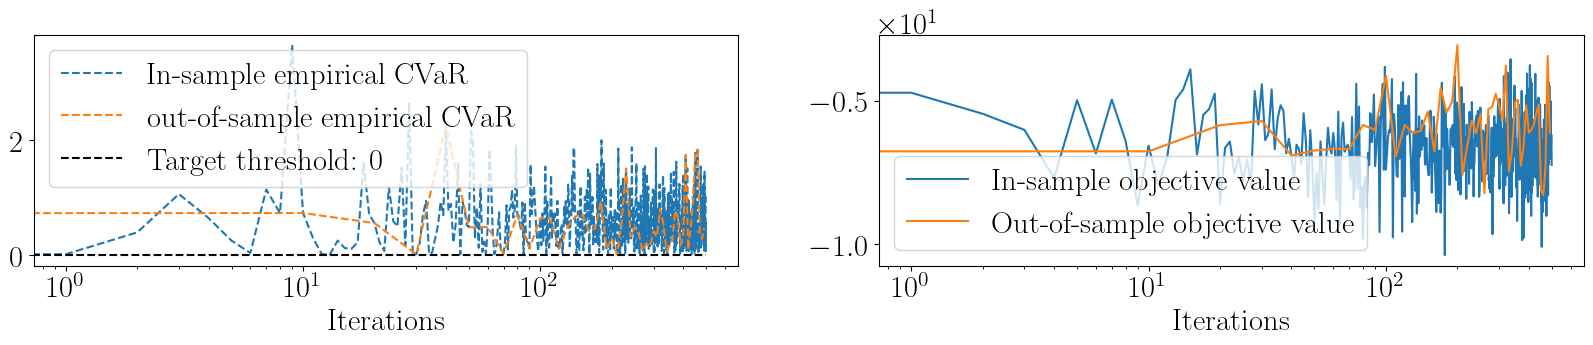

In [13]:
# training with linear NN - erratic balues
plot_iters(result.df,result.df_test, steps=num_iters, title="training")

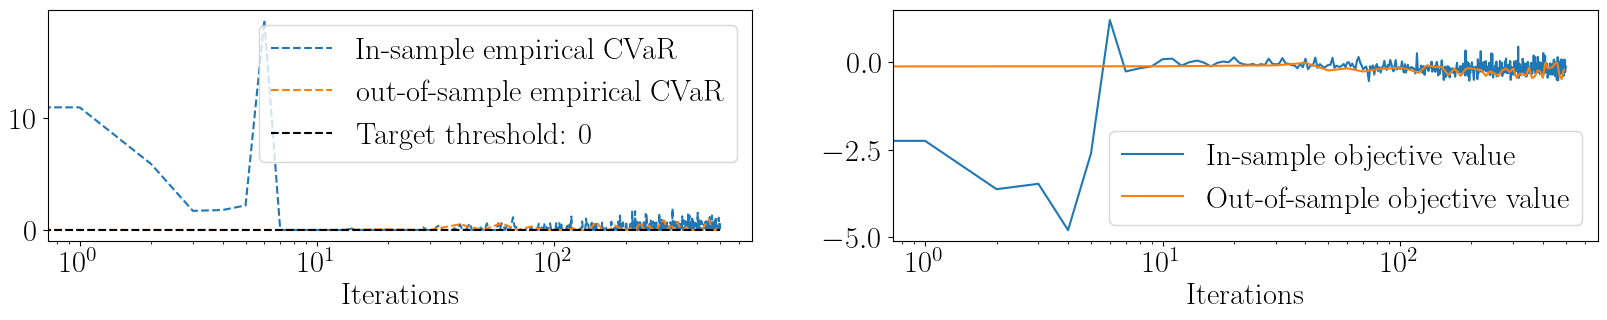

In [14]:
# training with covpred initialization - converges better but objective is much worse
plot_iters(result4.df,result4.df_test,steps=num_iters,title="training")

### plot tradeoff over radius

In [15]:
# Grid search epsilon
# mean variance set
result_grid = trainer.grid(rholst=eps_list, init_A=initn,
                    init_b=init_bvaln, seed=s,
                    init_alpha=0., test_percentage=test_p, quantiles = (0.3, 0.7))
dfgrid = result_grid.df
dfgrid.to_csv('mean_var_grid.csv')

In [16]:
epslst =eps_list
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
inds_untrained = []
inds_covpred_untrained = []
inds_covpred_trained = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Avg_prob_test']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Avg_prob_test']),axis = 1)-i).argmin())
    inds_untrained.append(np.absolute(np.mean(np.vstack(dfgrid3['Avg_prob_test']),axis = 1)-i).argmin())
    inds_covpred_untrained.append(np.absolute(np.mean(np.vstack(dfgrid4['Avg_prob_test']),axis = 1)-i).argmin())
    inds_covpred_trained.append(np.absolute(np.mean(np.vstack(dfgrid5['Avg_prob_test']),axis = 1)-i).argmin())

### scenario approach

In [17]:
def calc_eval(x,p,k,u,t):
  val = 0
  vio = 0
  for i in range(u.shape[0]):
    val_cur = k@x + np.max([-p[0]*x[0] - p[1]*x[1],-p[0]*x[0] - p[1]*u[i][1], -p[0]*u[i][0] - p[1]*x[1], -p[0]*u[i][0]- p[1]*u[i][1]]) 
    val+= val_cur
    vio += (val_cur >= t)
  return val/u.shape[0], vio/u.shape[0]
context_evals = 0
context_probs = 0
# solve for each context and average
for context in range(num_context):
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Scenario(
                                                        data=init_data[context][train_indices]))
    x_s = cp.Variable(n)
    t1 = cp.Variable()
    k1= init_k_data[context]
    p1 = init_p_data[context]
    objective = cp.Minimize(t1)
    constraints = [lropt.max_of_uncertain([-p1[0]*x_s[0] - p1[1]*x_s[1],
                                            -p1[0]*x_s[0] - p1[1]*u[1],
                                            -p1[0]*u[0] - p1[1]*x_s[1],
                                              -p1[0]*u[0]- p1[1]*u[1]])
                                              + k1@x_s <= t1]
    constraints += [x_s >= 0]

    prob_sc = lropt.RobustProblem(objective, constraints)
    prob_sc.solve()
    eval, prob_vio = calc_eval(x_s.value, init_p_data[context], init_k_data[context],init_data[context][test_indices],t1.value)
    context_evals += eval
    context_probs += prob_vio
context_evals = context_evals/num_context
context_probs = context_probs/num_context
print(context_evals, context_probs)

-5.955082048689179 0.23666666666666666


### nonrobust average

In [18]:
nonrob_evals = 0
nonrob_probs = 0
for context in range(num_context):
    for j in range(len(train_indices)):
        u = lropt.UncertainParameter(n,
                                uncertainty_set=lropt.Scenario(
                                                            data=init_data[context][train_indices][j:j+1]))
        x_s = cp.Variable(n)
        t1 = cp.Variable()
        k1= init_k_data[context]
        p1 = init_p_data[context]
        objective = cp.Minimize(t1)
        constraints = [lropt.max_of_uncertain([-p1[0]*x_s[0] - p1[1]*x_s[1],
                                                -p1[0]*x_s[0] - p1[1]*u[1],
                                                -p1[0]*u[0] - p1[1]*x_s[1],
                                                  -p1[0]*u[0]- p1[1]*u[1]])
                                                  + k1@x_s <= t1]
        constraints += [x_s >= 0]

        prob_sc = lropt.RobustProblem(objective, constraints)
        prob_sc.solve()
        eval, prob_vio = calc_eval(x_s.value, init_p_data[context], init_k_data[context],init_data[context][test_indices][j:j+1],t1.value)
        nonrob_evals += eval
        nonrob_probs += prob_vio
nonrob_evals = nonrob_evals / (num_context*len(train_indices))
nonrob_probs = nonrob_probs / (num_context*len(train_indices))
print(nonrob_evals,nonrob_probs)

-6.839100270344673 0.8466666666666667


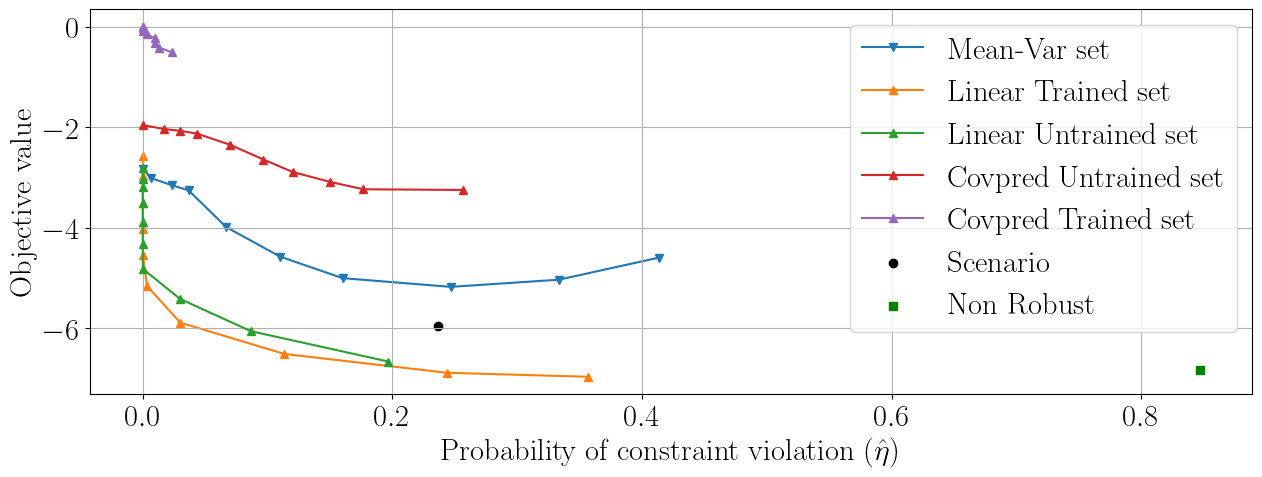

In [19]:
# indss = [5,9,13,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35]
# dfgrid, dfgrid2 = results_grid4[(16,0.3)]
beg1, end1 = 0, 100
beg2, end2 = 0, 100
plt.figure(figsize=(15, 5))
plt.plot(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[beg1:end1], np.mean(np.vstack(
    dfgrid['Test_val']), axis=1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker="v", zorder=0)
plt.plot(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid2['Test_val']), axis=1)[beg2:end2], color="tab:orange", label="Linear Trained set", marker="^", zorder=1)
plt.plot(np.mean(np.vstack(dfgrid3['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid3['Test_val']), axis=1)[beg2:end2], color="tab:green", label="Linear Untrained set", marker="^", zorder=2)
plt.plot(np.mean(np.vstack(dfgrid4['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid4['Test_val']), axis=1)[beg2:end2], color="tab:red", label="Covpred Untrained set", marker="^", zorder=3)
plt.plot(np.mean(np.vstack(dfgrid5['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid5['Test_val']), axis=1)[beg2:end2], color="tab:purple", label="Covpred Trained set", marker="^", zorder=4)
plt.ylabel("Objective value")
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
# plt.ylim([-9, 0])
plt.grid()
plt.scatter(context_probs,context_evals, color = "black", label="Scenario")
plt.scatter(nonrob_probs,nonrob_evals, color = "green", marker = "s", label="Non Robust")
plt.legend()
plt.savefig("news_objective_vs_violations.pdf", bbox_inches='tight')

It seems like for this seed, the reshaped set was able to get a slight improvement over the initialized set

In [20]:
K = 5
num_p = 50
offset = 5
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)

def gen_set(Amat,bvec,inds,K):
    fin_set = {}
    for ind in range(4):
        fin_set[ind] = {}
        for k_ind in range(K):
            fin_set[ind][k_ind] = np.zeros((num_p,num_p))
    for ind in range(4):
        for i in range(num_p):
            for j in range(num_p):
                u_vec = [x[i,j], y[i,j]]
                if K== 1:
                    fin_set[ind][0][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*(Amat.T@np.linalg.inv(Amat@Amat.T))@(u_vec - bvec))
                else:
                    for k_ind in range(K):
                        fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds[ind]])*(Amat[k_ind].T@np.linalg.inv(Amat[k_ind]@Amat[k_ind].T))@(u_vec - bvec[k_ind]))
    return fin_set
                
Amat = result._a_history[-1]*result.rho
bvec = result._b_history[-1]
fin_set = gen_set(Amat,bvec,inds_reshaped,K)
init_set = gen_set(initn,init_bvaln,inds_standard,K=1)
Amat2 = result2._a_history[-1]*result2.rho
bvec2 = result2._b_history[-1]
untrained_set = gen_set(Amat2,bvec2,inds_untrained,K)
Amat3 = result3._a_history[-1]*result3.rho
bvec3 = result3._b_history[-1]
covpred_set_untrained = gen_set(Amat3,bvec3,inds_covpred_untrained,K)
Amat4 = result4._a_history[-1]*result4.rho
bvec4 = result4._b_history[-1]
covpred_set_trained = gen_set(Amat4,bvec4,inds_covpred_trained,K)

In [21]:
def plot_contours_line(x,y,set, prob_list, train, title, K=1):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
    ax_lst = [ax1, ax2, ax3, ax4]
    np.random.seed(0)
    newtrain = np.random.choice(num_reps,size=15,replace=False)
    cur_ind = 0
    for axis in ax_lst:
        axis.set_title(r'$\hat{\eta}$' + ' = {}'.format(prob_list[cur_ind]))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["tab:green"])
        for k_ind in range(num_context):
            axis.scatter(init_data[k_ind][:,0][newtrain],init_data[k_ind][:,1][newtrain],edgecolor = "black")
        for k_ind in range(K):
            axis.contour(x,y,set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
        cur_ind +=1
    fig.suptitle(title +" set", fontsize = 30)
    plt.savefig(title+"_set"+ ".pdf", bbox_inches='tight')

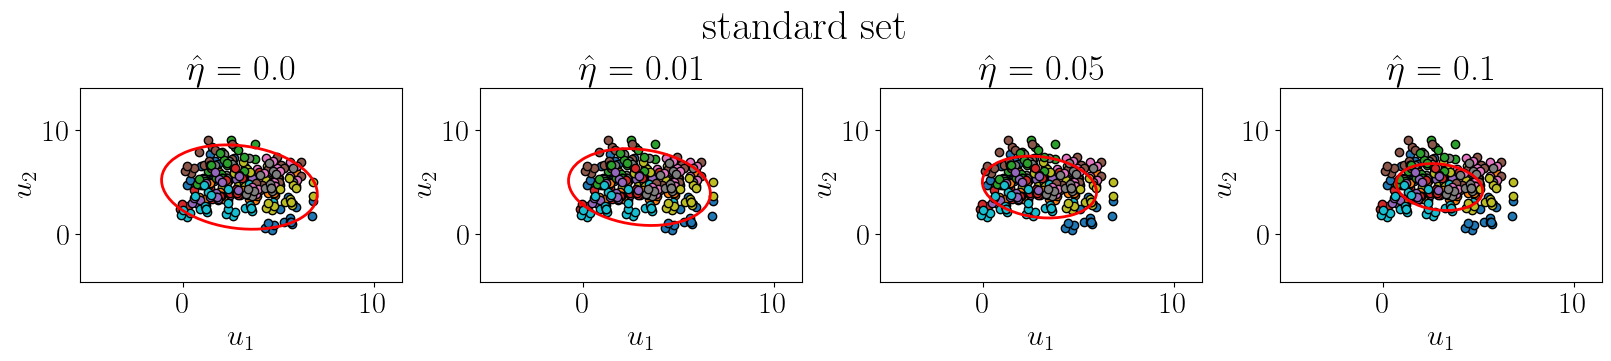

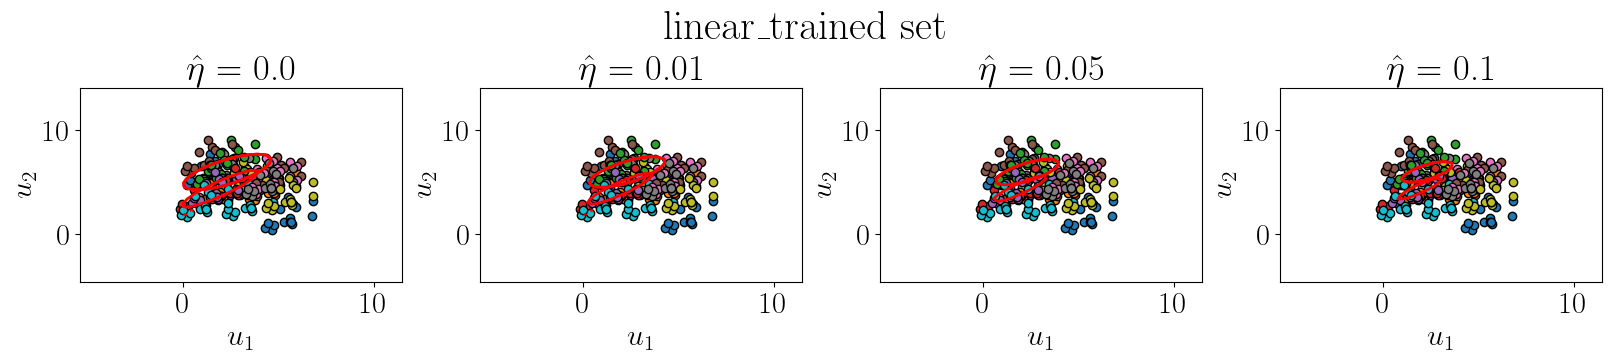

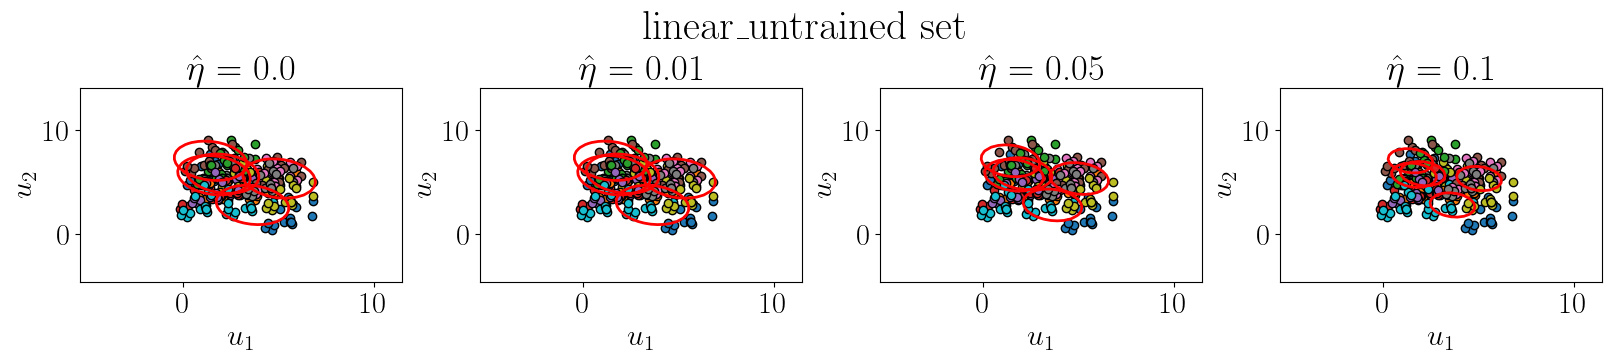

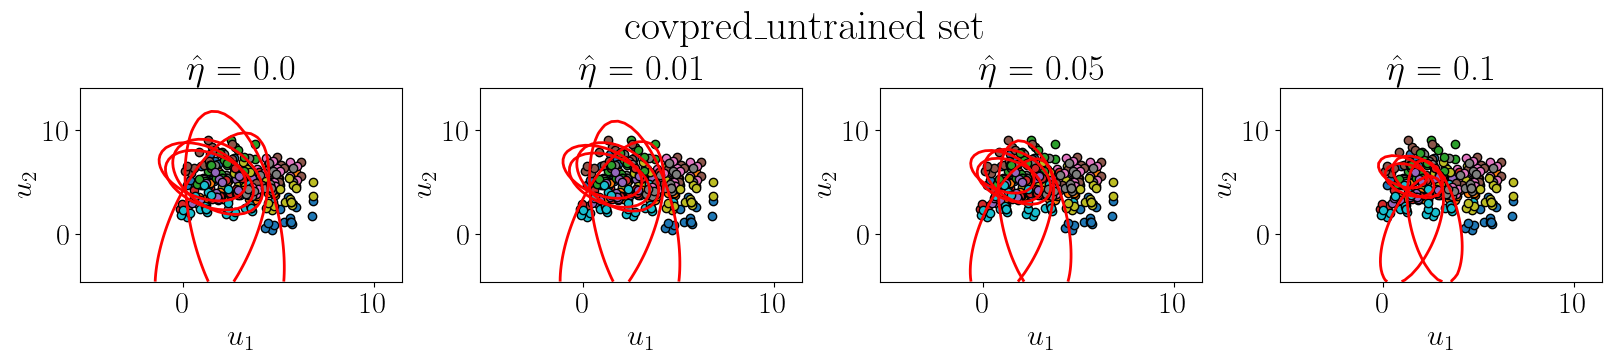

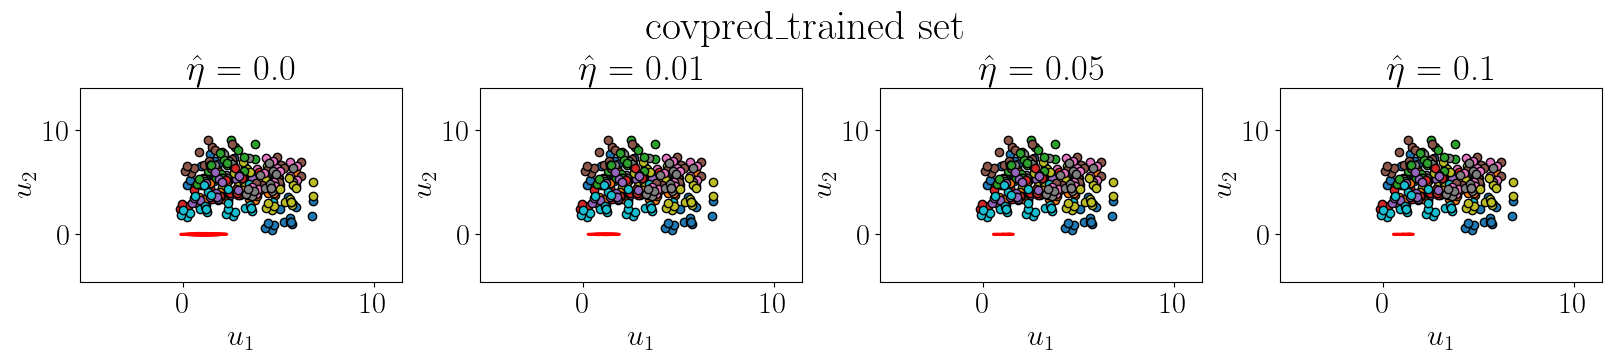

In [22]:
plot_contours_line(x,y,init_set,prob_list,train, "standard") 
plot_contours_line(x,y,fin_set, prob_list,train, "linear_trained", K=5)
plot_contours_line(x,y,untrained_set,prob_list,train, "linear_untrained", K=5)
plot_contours_line(x,y,covpred_set_untrained, prob_list,train, "covpred_untrained", K=5)
plot_contours_line(x,y,covpred_set_trained, prob_list,train, "covpred_trained", K=5)